In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.svm import SVC
from sklearn.semi_supervised import SelfTrainingClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, roc_curve, auc, classification_report
import warnings
import pickle
warnings.filterwarnings("ignore")

In [2]:
# Load the data from the file
file_path = "training_data.pkl"
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

# Access the X_train and y_train datasets from the loaded data dictionary
X = loaded_data["X_train"]
y = loaded_data["y_train"]

#### Training and Evaluating on Skewed Dataset

In [3]:
# The Dictionary to Store all different view of the data
skew_output_dict = {}

# First Using the Original Dataset
X_remaining, X_test, y_remaining, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1011)
scaler = StandardScaler()
X_remaining = scaler.fit_transform(X_remaining)
X_test = scaler.transform(X_test)

#### Fully Supervised i.e. 100% using Labeled Data

In [4]:
baseline = SVC(probability=True, gamma="auto",verbose=True)
baseline.fit(X_remaining,y_remaining)

# Generating Predictions on the Tests Sets
y_preds = baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_preds)
confusion_matrix_test = confusion_matrix(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}

skew_output_dict['1'] = result
print("Baseline Model Completed..")

[LibSVM]Baseline Model Completed..


In [5]:
print(skew_output_dict)

{'1': {'accuracy': 0.8984850160345018, 'confusion_matrix_test': array([[7849,  136],
       [ 782,  276]], dtype=int64), 'precision': 0.6699029126213593, 'recall': 0.2608695652173913, 'f1': 0.37551020408163266, 'fpr': array([0.        , 0.01703193, 1.        ]), 'tpr': array([0.        , 0.26086957, 1.        ]), 'thresholds': array([2, 1, 0]), 'roc_auc': 0.6219188151697477}}


#### Training the model with 50%, 75%, 90%, 95% and 99% unlabeled data

In [7]:
unlabeled_data_perc = [0.5,0.25,0.1,0.05,0.01]

for i,perc in enumerate(unlabeled_data_perc):
    # Further split the remaining data into Labelled data and Unlabeled data
    print(f"Iteration: {i+1}, Unlabeled Data Percentage: {perc*100}%")
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_remaining,
                                                                      y_remaining, 
                                                                      train_size=perc, 
                                                                      stratify=y_remaining, 
                                                                      random_state=1011)
    #Removing the Labels of Unlabeled Data
    y_unlabeled[:] = -1
    
    #Temporary Variables
    X_tmp = np.concatenate([X_labeled, X_unlabeled], axis=0)
    y_tmp = pd.concat([y_labeled,y_unlabeled],axis=0).values
    
    #Creating a estimator
    svc = SVC(probability=True, gamma="auto")
    
    #Training the Self Training Model
    self_training_model = SelfTrainingClassifier(svc,verbose=True,max_iter=3,threshold=0.70)
    self_training_model.fit(X_tmp, y_tmp)
    
    print("Model Fitting Completed..")
    
    #Generating Predictions
    y_preds = self_training_model.predict(X_test)
    
    print("Model Predictions Completed..")
    
    #Calculating Metrics
    accuracy = accuracy_score(y_test, y_preds)
    confusion_matrix_test = confusion_matrix(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test,y_preds)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    
    result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}
    print("Results Dict Generated..")
    skew_output_dict[str(i+2)] = result
    print()

Iteration: 1, Unlabeled Data Percentage: 50.0%
End of iteration 1, added 17500 new labels.
End of iteration 2, added 403 new labels.
End of iteration 3, added 106 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 2, Unlabeled Data Percentage: 25.0%
End of iteration 1, added 26109 new labels.
End of iteration 2, added 748 new labels.
End of iteration 3, added 196 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 3, Unlabeled Data Percentage: 10.0%
End of iteration 1, added 31347 new labels.
End of iteration 2, added 960 new labels.
End of iteration 3, added 161 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 4, Unlabeled Data Percentage: 5.0%
End of iteration 1, added 32944 new labels.
End of iteration 2, added 1141 new labels.
End of iteration 3, added 205 new labels.
Model Fitting Completed..
Model Predictions Completed.

In [ ]:
# Print the shapes and types of all variables
# print("Shape of X_remaining:", X_remaining.shape, "Type:", type(X_remaining))
# print("Shape of X_test:", X_test.shape, "Type:", type(X_test))
# print("Shape of y_remaining:", y_remaining.shape, "Type:", type(y_remaining))
# print("Shape of y_test:", y_test.shape, "Type:", type(y_test))
# print("Shape of X_labeled:", X_labeled.shape, "Type:", type(X_labeled))
# print("Shape of X_unlabeled:", X_unlabeled.shape, "Type:", type(X_unlabeled))
# print("Shape of y_labeled:", y_labeled.shape, "Type:", type(y_labeled))
# print("Shape of y_unlabeled:", y_unlabeled.shape, "Type:", type(y_unlabeled))

In [8]:
output_file = 'self_training_op_skew.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(skew_output_dict, file)
print(skew_output_dict)

{'1': {'accuracy': 0.8984850160345018, 'confusion_matrix_test': array([[7849,  136],
       [ 782,  276]], dtype=int64), 'precision': 0.6699029126213593, 'recall': 0.2608695652173913, 'f1': 0.37551020408163266, 'fpr': array([0.        , 0.01703193, 1.        ]), 'tpr': array([0.        , 0.26086957, 1.        ]), 'thresholds': array([2, 1, 0]), 'roc_auc': 0.6219188151697477}, '2': {'accuracy': 0.8926241291606768, 'confusion_matrix_test': array([[7843,  142],
       [ 829,  229]], dtype=int64), 'precision': 0.6172506738544474, 'recall': 0.21644612476370512, 'f1': 0.32050384884534644, 'fpr': array([0.        , 0.01778334, 1.        ]), 'tpr': array([0.        , 0.21644612, 1.        ]), 'thresholds': array([2, 1, 0]), 'roc_auc': 0.5993313904970686}, '3': {'accuracy': 0.8924029636182683, 'confusion_matrix_test': array([[7858,  127],
       [ 846,  212]], dtype=int64), 'precision': 0.6253687315634219, 'recall': 0.2003780718336484, 'f1': 0.3035075161059413, 'fpr': array([0.        , 0.01590

#### Results on skewed Dataset

In [32]:
# Print all metrics for each model
labeled_data_perc = [1.0,0.5,0.25,0.1,0.05,0.01]
for model_num, metrics in skew_output_dict.items():
    print(f"Model {model_num} Metrics: {100 - (labeled_data_perc[int(model_num)-1])*100}% of Unlabeled Data")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1']}\n")

Model 1 Metrics: 0.0% of Unlabeled Data
Accuracy: 0.8984850160345018
Precision: 0.6699029126213593
Recall: 0.2608695652173913
F1 Score: 0.37551020408163266

Model 2 Metrics: 50.0% of Unlabeled Data
Accuracy: 0.8926241291606768
Precision: 0.6172506738544474
Recall: 0.21644612476370512
F1 Score: 0.32050384884534644

Model 3 Metrics: 75.0% of Unlabeled Data
Accuracy: 0.8924029636182683
Precision: 0.6253687315634219
Recall: 0.2003780718336484
F1 Score: 0.3035075161059413

Model 4 Metrics: 90.0% of Unlabeled Data
Accuracy: 0.8932876257879022
Precision: 0.6201550387596899
Recall: 0.22684310018903592
F1 Score: 0.3321799307958478

Model 5 Metrics: 95.0% of Unlabeled Data
Accuracy: 0.892734711931881
Precision: 0.6208791208791209
Recall: 0.21361058601134217
F1 Score: 0.3178621659634318

Model 6 Metrics: 99.0% of Unlabeled Data
Accuracy: 0.8807917726418224
Precision: 0.4107142857142857
Recall: 0.043478260869565216
F1 Score: 0.07863247863247863



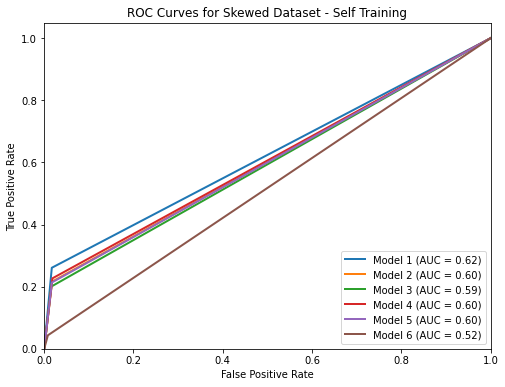

In [45]:
plt.figure(figsize=(8, 6))
for model_num, metrics in skew_output_dict.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['roc_auc']
    plt.plot(fpr, tpr, lw=2, label='Model {} (AUC = {:.2f})'.format(model_num, roc_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Skewed Dataset - Self Training')
plt.legend(loc="lower right")
plt.savefig('ROC Curves for Skewed Dataset - Self Training.png')
plt.show()

#### Training and Evaluation in Undersampled Dataset

In [11]:
# The Dictionary to Store all different view of the data
nearmiss_output_dict = {}
X_nearmiss = loaded_data['X_train_nearmiss']
y_nearmiss = loaded_data['y_train_nearmiss']

# First Using the Original Dataset
X_remaining, X_test, y_remaining, y_test = train_test_split(X_nearmiss, y_nearmiss, test_size=0.2, stratify=y_nearmiss, random_state=1011)
scaler = StandardScaler()
X_remaining = scaler.fit_transform(X_remaining)
X_test = scaler.transform(X_test)

#### Fully Supervised i.e. 100% using Labeled Data

In [12]:
baseline = SVC(probability=True, gamma="auto")
baseline.fit(X_remaining,y_remaining)

# Generating Predictions on the Tests Sets
y_preds = baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_preds)
confusion_matrix_test = confusion_matrix(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}

nearmiss_output_dict['1'] = result
print("Undersampled Baseline Model Completed..")

Undersampled Baseline Model Completed..


#### Training the model with 50%, 75%, 90%, 95% and 99% unlabeled data

In [13]:
unlabeled_data_perc = [0.5,0.25,0.1,0.05,0.01]

for i,perc in enumerate(unlabeled_data_perc):
    # Further split the remaining data into Labelled data and Unlabeled data
    print(f"Iteration: {i+1}, Unlabeled Data Percentage: {perc*100}%")
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_remaining,
                                                                      y_remaining, 
                                                                      train_size=perc, 
                                                                      stratify=y_remaining, 
                                                                      random_state=1011)
    #Removing the Labels of Unlabeled Data
    y_unlabeled[:] = -1
    
    #Temporary Variables
    X_tmp = np.concatenate([X_labeled, X_unlabeled], axis=0)
    y_tmp = pd.concat([y_labeled,y_unlabeled],axis=0).values
    
    #Creating a estimator
    svc = SVC(probability=True, gamma="auto")
    
    #Training the Self Training Model
    self_training_model = SelfTrainingClassifier(svc,verbose=True,max_iter=3,threshold=0.70)
    self_training_model.fit(X_tmp, y_tmp)
    print("Model Fitting Completed..")
    
    #Generating Predictions
    y_preds = self_training_model.predict(X_test)
    print("Model Predictions Completed..")
    
    #Calculating Metrics
    accuracy = accuracy_score(y_test, y_preds)
    confusion_matrix_test = confusion_matrix(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test,y_preds)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    
    result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}
    print("Results Dict Generated..")
    nearmiss_output_dict[str(i+2)] = result
    print()

Iteration: 1, Unlabeled Data Percentage: 50.0%
End of iteration 1, added 2423 new labels.
End of iteration 2, added 817 new labels.
End of iteration 3, added 285 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 2, Unlabeled Data Percentage: 25.0%
End of iteration 1, added 3427 new labels.
End of iteration 2, added 1795 new labels.
End of iteration 3, added 530 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 3, Unlabeled Data Percentage: 10.0%
End of iteration 1, added 3356 new labels.
End of iteration 2, added 3082 new labels.
End of iteration 3, added 701 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 4, Unlabeled Data Percentage: 5.0%
End of iteration 1, added 2814 new labels.
End of iteration 2, added 3794 new labels.
End of iteration 3, added 923 new labels.
Model Fitting Completed..
Model Predictions Completed..


In [14]:
output_file = 'self_training_op_nearmiss.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(nearmiss_output_dict, file)

#### Evaluation on Undersampled Dataset

In [38]:
# Print all metrics for each model
labeled_data_perc = [1.0,0.5,0.25,0.1,0.05,0.01]
for model_num, metrics in nearmiss_output_dict.items():
    print(f"Model {model_num} Metrics: {100 - (labeled_data_perc[int(model_num)-1])*100}% of Unlabeled Data")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1']}\n")

Model 1 Metrics: 0.0% of Unlabeled Data
Accuracy: 0.6994328922495274
Precision: 0.6935779816513762
Recall: 0.7145557655954632
F1 Score: 0.7039106145251397

Model 2 Metrics: 50.0% of Unlabeled Data
Accuracy: 0.6810018903591682
Precision: 0.6714413607878246
Recall: 0.7088846880907372
F1 Score: 0.6896551724137931

Model 3 Metrics: 75.0% of Unlabeled Data
Accuracy: 0.6639886578449905
Precision: 0.6657115568290354
Recall: 0.6587901701323251
F1 Score: 0.6622327790973871

Model 4 Metrics: 90.0% of Unlabeled Data
Accuracy: 0.6720226843100189
Precision: 0.6616341030195382
Recall: 0.7041587901701323
F1 Score: 0.6822344322344321

Model 5 Metrics: 95.0% of Unlabeled Data
Accuracy: 0.6625708884688091
Precision: 0.6580882352941176
Recall: 0.6767485822306238
F1 Score: 0.6672879776328053

Model 6 Metrics: 99.0% of Unlabeled Data
Accuracy: 0.6049149338374291
Precision: 0.5776223776223777
Recall: 0.780718336483932
F1 Score: 0.6639871382636656



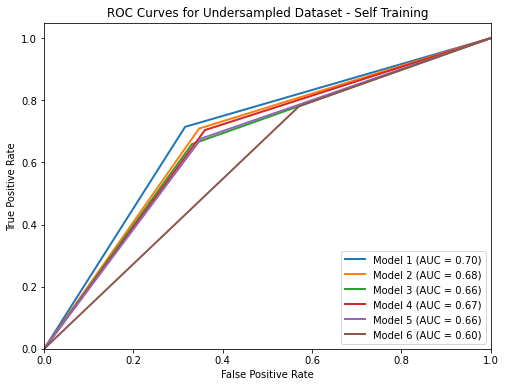

In [43]:
plt.figure(figsize=(8, 6))
for model_num, metrics in nearmiss_output_dict.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['roc_auc']
    plt.plot(fpr, tpr, lw=2, label='Model {} (AUC = {:.2f})'.format(model_num, roc_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Undersampled Dataset - Self Training')
plt.legend(loc="lower right")
plt.savefig('ROC Curves for Undersampled Dataset - Self Training.png')
plt.show()

#### Training and Evaluation in Oversampled Dataset

In [15]:
# The Dictionary to Store all different view of the data
smote_output_dict = {}
X_smote = loaded_data['X_train_smote']
y_smote = loaded_data['y_train_smote']
# First Using the Original Dataset
X_remaining, X_test, y_remaining, y_test = train_test_split(X_smote, y_smote, test_size=0.2, stratify=y_smote, random_state=1011)
scaler = StandardScaler()
X_remaining = scaler.fit_transform(X_remaining)
X_test = scaler.transform(X_test)

#### Fully Supervised i.e. 100% using Labeled Data

In [16]:
baseline = SVC(probability=True, gamma="auto")
baseline.fit(X_remaining,y_remaining)

# Generating Predictions on the Tests Sets
y_preds = baseline.predict(X_test)

accuracy = accuracy_score(y_test, y_preds)
confusion_matrix_test = confusion_matrix(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)
f1 = f1_score(y_test,y_preds)

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_preds)
roc_auc = auc(fpr, tpr)

result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}

smote_output_dict['1'] = result
print("Oversampled Baseline Model Completed..")

Oversampled Baseline Model Completed..


#### Training the model with 50%, 75%, 90%, 95% and 99% unlabeled data

In [18]:
unlabeled_data_perc = [0.5,0.25,0.1,0.05,0.01]

for i,perc in enumerate(unlabeled_data_perc):
    # Further split the remaining data into Labelled data and Unlabeled data
    print(f"Iteration: {i+1}, labeled Data Percentage: {perc*100}%")
    X_labeled, X_unlabeled, y_labeled, y_unlabeled = train_test_split(X_remaining,
                                                                      y_remaining, 
                                                                      train_size=perc, 
                                                                      stratify=y_remaining, 
                                                                      random_state=1011)
    #Removing the Labels of Unlabeled Data
    y_unlabeled[:] = -1
    
    #Temporary DataFrames
    X_tmp = np.concatenate([X_labeled, X_unlabeled], axis=0)
    y_tmp = pd.concat([y_labeled,y_unlabeled],axis=0).values
    
    #Creating a estimator
    svc = SVC(probability=True, gamma="auto")
    
    #Training the Self Training Model
    self_training_model = SelfTrainingClassifier(svc,verbose=True,max_iter=3,threshold=0.70)
    self_training_model.fit(X_tmp, y_tmp)
    
    print("Model Fitting Completed..")
    
    #Generating Predictions
    y_preds = self_training_model.predict(X_test)
    
    print("Model Predictions Completed..")
    
    #Calculating Metrics
    accuracy = accuracy_score(y_test, y_preds)
    confusion_matrix_test = confusion_matrix(y_test, y_preds)
    precision = precision_score(y_test, y_preds)
    recall = recall_score(y_test, y_preds)
    f1 = f1_score(y_test,y_preds)
    
    # ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_preds)
    roc_auc = auc(fpr, tpr)
    
    result = {"accuracy":accuracy,
          "confusion_matrix_test":confusion_matrix_test,
          "precision":precision,
          "recall":recall,
          "f1":f1,
          "fpr":fpr,
          "tpr":tpr,
          "thresholds":thresholds,
          "roc_auc":roc_auc}
    print("Results Dict Generated..")
    smote_output_dict[str(i+2)] = result
    print()

Iteration: 1, labeled Data Percentage: 50.0%
End of iteration 1, added 31030 new labels.
End of iteration 2, added 492 new labels.
End of iteration 3, added 168 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 2, labeled Data Percentage: 25.0%
End of iteration 1, added 46249 new labels.
End of iteration 2, added 1118 new labels.
End of iteration 3, added 270 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 3, labeled Data Percentage: 10.0%
End of iteration 1, added 55074 new labels.
End of iteration 2, added 1860 new labels.
End of iteration 3, added 298 new labels.
Model Fitting Completed..
Model Predictions Completed..
Results Dict Generated..

Iteration: 4, labeled Data Percentage: 5.0%
End of iteration 1, added 57784 new labels.
End of iteration 2, added 2280 new labels.
End of iteration 3, added 311 new labels.
Model Fitting Completed..
Model Predictions Completed..
Resu

In [19]:
output_file = 'self_training_op_smote.pkl'
with open(output_file, 'wb') as file:
    pickle.dump(smote_output_dict, file)

#### Evaluation on Oversampled Dataset

In [40]:
# Print all metrics for each model
labeled_data_perc = [1.0,0.5,0.25,0.1,0.05,0.01]
for model_num, metrics in smote_output_dict.items():
    print(f"Model {model_num} Metrics: {100 - (labeled_data_perc[int(model_num)-1])*100}% of Unlabeled Data")
    print(f"Accuracy: {metrics['accuracy']}")
    print(f"Precision: {metrics['precision']}")
    print(f"Recall: {metrics['recall']}")
    print(f"F1 Score: {metrics['f1']}\n")

Model 1 Metrics: 0.0% of Unlabeled Data
Accuracy: 0.935249545995366
Precision: 0.9778633301251203
Recall: 0.8906700062617408
F1 Score: 0.9322322715952287

Model 2 Metrics: 50.0% of Unlabeled Data
Accuracy: 0.9314296449370656
Precision: 0.9778085991678225
Recall: 0.8829054477144647
F1 Score: 0.9279368213228036

Model 3 Metrics: 75.0% of Unlabeled Data
Accuracy: 0.9314922662658902
Precision: 0.9784752117761422
Recall: 0.8824045084533501
F1 Score: 0.92795996312393

Model 4 Metrics: 90.0% of Unlabeled Data
Accuracy: 0.9302398396893982
Precision: 0.9757651294834511
Recall: 0.8824045084533501
F1 Score: 0.9267394449559385

Model 5 Metrics: 95.0% of Unlabeled Data
Accuracy: 0.9302398396893982
Precision: 0.9749758053366515
Recall: 0.883155917345022
F1 Score: 0.9267972138257329

Model 6 Metrics: 99.0% of Unlabeled Data
Accuracy: 0.9122048969879141
Precision: 0.9453389257204708
Recall: 0.8750156543519099
F1 Score: 0.9088189386056191



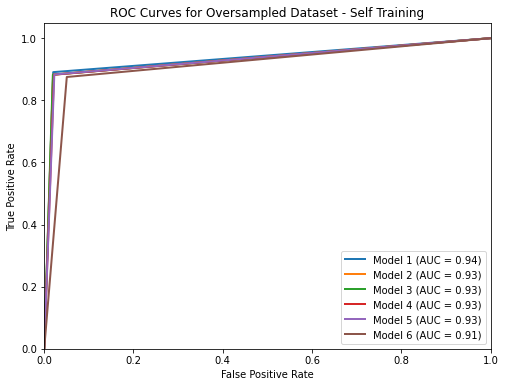

In [42]:
plt.figure(figsize=(8, 6))
for model_num, metrics in smote_output_dict.items():
    fpr = metrics['fpr']
    tpr = metrics['tpr']
    roc_auc = metrics['roc_auc']
    plt.plot(fpr, tpr, lw=2, label='Model {} (AUC = {:.2f})'.format(model_num, roc_auc))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Oversampled Dataset - Self Training')
plt.legend(loc="lower right")
plt.savefig('ROC Curves for Oversampled Dataset - Self Training.png')
plt.show()